In [1]:
import os
import csv
import math
import pickle
import random
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

from sklearn.metrics import roc_auc_score

from ray import tune
from ray.tune import CLIReporter
from ray.tune.schedulers import ASHAScheduler
from ray.tune import ExperimentAnalysis

In [2]:
def seed_everything(seed: int):
    random.seed(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = True


seed_everything(1234)

In [3]:
def read_data(path):
    with open(path, 'r') as f:
        seqs, lbls = [], []
        for l in f.readlines()[1:]:
            seq, lbl = l.strip().split('\t')
            seqs.append(seq)
            lbls.append(lbl)
    return seqs, lbls

def read_embeddings(path):
    with open(path, 'r') as f:
        seq, vec = [], []
        for line in f.readlines()[2:]: # skip first special chars
            lst = line.split()
            seq.append(lst[0].upper())
            vec.append([float(i) for i in lst[1:]])
        vocab = {s: i for i, s in enumerate(seq)}
        prot2vec = torch.tensor(vec, dtype=torch.float)
    return vocab, prot2vec

# encodes kmer sequence
encode_text = lambda seq: [vocab.get(s, 0) for s in seq.split()]

def apply_random_masking(seq, num_tokens):
    """
    Mask `num_tokens` as 0 at random positions per sequence. 
    """
    dist = torch.rand(seq.shape)
    m, _ = torch.topk(dist, num_tokens)
    return seq * (dist < m)

def gelu(x):
    """
    Facebook Research implementation of the gelu activation function.
    
    For information: OpenAI GPT's gelu is slightly different
    (and gives slightly different results):
    0.5 * x * (1 + torch.tanh(math.sqrt(2 / math.pi) * (x + 0.044715 * torch.pow(x, 3))))
    """
    return x * 0.5 * (1.0 + torch.erf(x / math.sqrt(2.0)))

def regularized_auc(train_auc, dev_auc, threshold=0.0025):
    """
    Returns development AUC if overfitting is below threshold, otherwise 0.
    """
    return dev_auc if (train_auc - dev_auc) < threshold else 0

In [4]:
class CleavageDataset(Dataset):
    def __init__(self, seq, lbl):
        self.seq = seq
        self.lbl = lbl
    
    def __getitem__(self, idx):
        return self.seq[idx], self.lbl[idx]
    
    def __len__(self):
        return len(self.lbl)
    
def collate_train(batch):
    ordered_batch = list(zip(*batch))
    seq = torch.tensor([encode_text(seq) for seq in ordered_batch[0]], dtype=torch.int64)
    seq = apply_random_masking(seq, num_tokens=1)
    lbl = torch.tensor([int(l) for l in ordered_batch[1]], dtype=torch.float)
    return seq, lbl

def collate_dev(batch):
    ordered_batch = list(zip(*batch))
    seq = torch.tensor([encode_text(seq) for seq in ordered_batch[0]], dtype=torch.int64)
    lbl = torch.tensor([int(l) for l in ordered_batch[1]], dtype=torch.float)
    return seq, lbl

In [5]:
class BiLSTM(nn.Module):
    def __init__(self, pretrained_embeds, rnn_size, hidden_size, dropout):
        super().__init__()
        
        embeding_dim = pretrained_embeds.shape[1]
        
        self.embedding = nn.Embedding.from_pretrained(
            embeddings=pretrained_embeds,
            freeze=True
        )
        
        self.dropout=nn.Dropout(dropout)
        
        self.lstm = nn.LSTM(
            input_size=embeding_dim,
            hidden_size=rnn_size,
            bidirectional=True,
            batch_first=True,
        )
        
        self.fc1 = nn.Linear(rnn_size * 2, hidden_size)
        self.fc2 = nn.Linear(hidden_size, 1)
        
    def forward(self, seq):
        # input shape: (batch_size, seq_len=10)
        embedded = self.dropout(self.embedding(seq))
        
        # input shape: (batch_size, seq_len, embedding_dim)
        out, _ = self.lstm(embedded)
        
        # input shape: (batch_size, seq_len, 2*hidden_size)
        pooled, _ = torch.max(out, dim=1)
        
        # input shape: (batch_size, 2*hidden_size)
        out = self.dropout(gelu(self.fc1(pooled)))
        
        # input shape: (batch_size, hidden_size)
        # output shape: (batch_size)
        return self.fc2(out).squeeze() 

In [6]:
def process(model, loader, criterion, optim=None):
    epoch_loss, num_correct, total = 0, 0, 0
    preds, lbls = [], []
    
    for seq, lbl in loader:
        seq, lbl = seq.to(device), lbl.to(device)
        
        scores = model(seq)
        loss = criterion(scores, lbl)
        
        if optim is not None:
            optim.zero_grad()
            loss.backward()
            optim.step()
        
        epoch_loss += loss.item()
        num_correct += ((scores > 0) == lbl).sum().item()
        total += seq.shape[0]
        preds.extend(scores.detach().tolist())
        lbls.extend(lbl.detach().tolist())
    return epoch_loss / total, num_correct / total, roc_auc_score(lbls, preds)

In [7]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# load train and dev data
train_seqs, train_lbl = read_data('../../data/c_train_3mer.tsv')
dev_seqs, dev_lbl = read_data('../../data/c_val_3mer.tsv')

# load vocab and embeddings
vocab, prot2vec = read_embeddings('../../params/uniref_3M/uniref_3M.vec')

In [8]:
NUM_EPOCHS = 40
VOCAB_SIZE = len(vocab)

def train(config, checkpoint_dir=None):
    
    # create train and dev loader
    train_data = CleavageDataset(train_seqs, train_lbl)
    train_loader = DataLoader(train_data, batch_size=512, shuffle=True, collate_fn=collate_train, num_workers=8)

    dev_data = CleavageDataset(dev_seqs, dev_lbl)
    dev_loader = DataLoader(dev_data, batch_size=512, shuffle=True, collate_fn=collate_dev, num_workers=8)
    
    
    model = BiLSTM(
        pretrained_embeds=prot2vec,
        rnn_size=config['rnn_size'],
        hidden_size=config['hidden_size'],
        dropout=config['dropout'],
    ).to(device)
    
    optimizer = optim.Adam(model.parameters(), lr=config['lr'])
    criterion = nn.BCEWithLogitsLoss()
    
    # normal train loop
    for epoch in range(1, NUM_EPOCHS + 1):
        model.train()
        train_loss, train_acc, train_auc = process(model, train_loader, criterion, optimizer)
        
        model.eval()
        with torch.no_grad():
            val_loss, val_acc, val_auc = process(model, dev_loader, criterion)
        
        with tune.checkpoint_dir(step=epoch) as checkpoint_dir:
            checkpoint_path = os.path.join(checkpoint_dir, "checkpoint.pt")
            torch.save(model.state_dict(), checkpoint_path)
            
        # metrics that will be reported back to main process
        reg_auc = regularized_auc(train_auc, val_auc)
        
        tune.report(
            train_loss=train_loss,
            dev_loss=val_loss,
            train_acc=train_acc,
            dev_acc=val_acc,
            train_auc=train_auc,
            dev_auc=val_auc,
            reg_auc=reg_auc,
        )
        
        # if model is overfitting, stop the run
        if reg_auc == 0:
            break

In [9]:
class TuneReporter(CLIReporter):
    def __init__(self):
        super().__init__()
        self.num_terminated = 0

    def should_report(self, trials, done=False):
        """Reports only on trial termination events."""
        old_num_terminated = self.num_terminated
        self.num_terminated = len([t for t in trials if t.status == "TERMINATED"])
        return self.num_terminated > old_num_terminated
    
    def report(self, trials, done, *sys_info):
        print(self._progress_str(trials, done, *sys_info))
    
reporter = TuneReporter()
reporter.add_metric_column(metric='train_loss')
reporter.add_metric_column(metric='dev_loss')
reporter.add_metric_column(metric='train_acc')
reporter.add_metric_column(metric='dev_acc')
reporter.add_metric_column(metric='train_auc')
reporter.add_metric_column(metric='dev_auc')
reporter.add_metric_column(metric='reg_auc')

In [10]:
search_space = {
    'rnn_size': tune.randint(480, 531),
    'hidden_size': tune.randint(120, 180),
    'dropout': tune.quniform(0.45, 0.52, 0.01),
    'lr': tune.qloguniform(8e-5, 1e-3, 5e-6),
}

In [ ]:
path = '../../params/c_term/BiLSTM_prot2vec/'
experiment = 'search'
num_samples = 30

analysis = tune.run(
    train,
    name=experiment,
    config=search_space,
    sync_config=tune.SyncConfig(syncer=None),
    num_samples=num_samples,
    scheduler=ASHAScheduler(
        metric='reg_auc',
        mode='max',
        max_t=35,
        reduction_factor=2,
        grace_period=4
    ),
    progress_reporter=reporter,
    local_dir=path,
    keep_checkpoints_num=None, # keep all checkpoints
    checkpoint_score_attr='reg_auc',
    resume='AUTO',
    resources_per_trial={'cpu': 16, 'gpu': 1},
)

In [12]:
ana = ExperimentAnalysis(path + experiment)

2022-09-13 00:05:18,574	INFO experiment_analysis.py:757 -- No `self.trials`. Drawing logdirs from checkpoint file. This may result in some information that is out of sync, as checkpointing is periodic.


In [13]:
df = ana.dataframe()
cols_needed = [col for col in df.columns if col.startswith('config/')]

In [14]:
df[['train_auc', 'dev_auc', 'reg_auc', 'training_iteration', *cols_needed]].sort_values(by='reg_auc', ascending=False)

,train_auc,dev_auc,reg_auc,training_iteration,config/dropout,config/hidden_size,config/lr,config/rnn_size
28,0.867526,0.876615,0.876615,8,0.51,150,0.000475,497
10,0.866875,0.876209,0.876209,8,0.52,121,0.000455,521
8,0.865282,0.876045,0.876045,8,0.51,161,0.000380,500
29,0.864458,0.875486,0.875486,8,0.50,132,0.000365,492
20,0.863138,0.874911,0.874911,8,0.52,139,0.000350,525
23,0.862173,0.874591,0.874591,8,0.49,176,0.000310,486
16,0.862128,0.874045,0.874045,8,0.47,141,0.000285,498
24,0.856931,0.871658,0.871658,8,0.46,161,0.000205,480
4,0.832584,0.862546,0.862546,4,0.51,135,0.000220,521
26,0.826667,0.859418,0.859418,4,0.52,177,0.000180,499


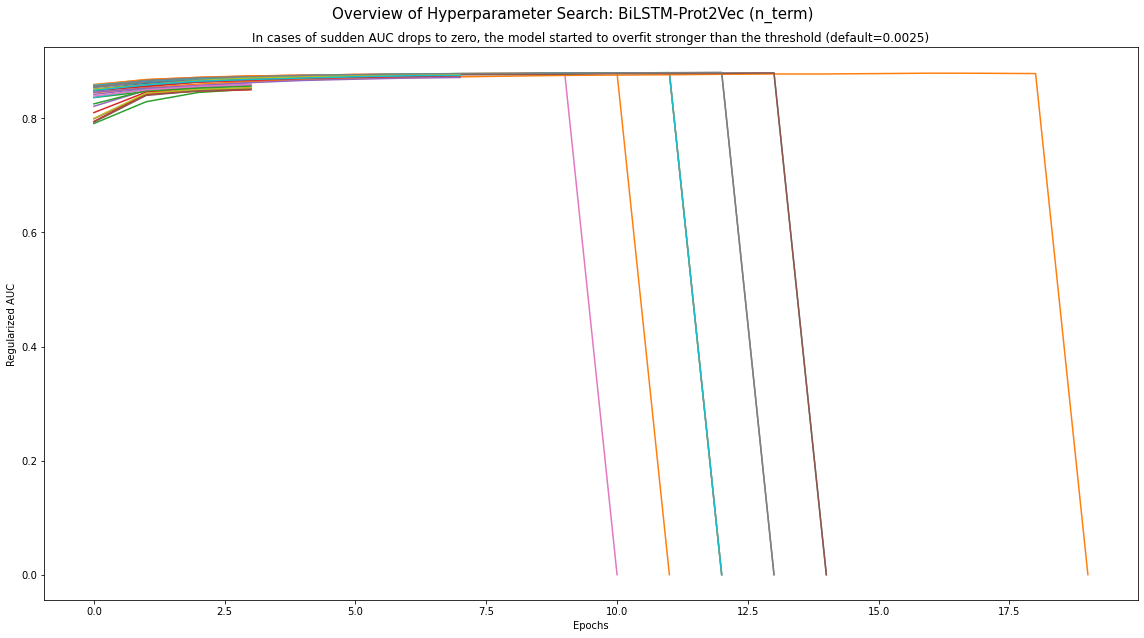

In [15]:
### when the acc suddenly drops to zero, that's when the model started to overfit stronger than the threshold (default=0.0025) 
plt.figure(figsize=(16, 9))
ax = None
for val in ana.trial_dataframes.values():
    ax = val.reg_auc.plot(ax=ax, legend=False)
plt.xlabel('Epochs')
plt.ylabel('Regularized AUC')
plt.suptitle('Overview of Hyperparameter Search: BiLSTM-Prot2Vec (n_term)', fontsize=15, ha='center')
plt.title("In cases of sudden AUC drops to zero, the model started to overfit stronger than the threshold (default=0.0025)", fontsize=12, ha='center')
plt.tight_layout()
plt.show()